In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# MNISTデータのダウンロード
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
# 各種行列を生成する関数
def weight_variable(shape, name):
    initial = tf.random_normal(shape,stddev=0.02)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.random_normal(shape, stddev=0.02)
    return tf.Variable(initial, name=name)

In [18]:
def batch_normalizaiton( x, axes=[0] ):
    mean, variance = tf.nn.moments( x, axes )
    return tf.nn.batch_normalization( x, mean, variance, None, None, 1e-5 )

def conv2d(x, W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def leaky_relu(input):
    return tf.maximum(0.2*input, input)

In [19]:
batch_size = 100
latent_dim = 100

In [38]:
# generator
def generate( Z ):
    ## 全結合
    W1 = weight_variable( [latent_dim, 1024], "g_w1" )
    b1 = bias_variable( [1024] , "g_b1")
    fc1 = tf.matmul( Z, W1 ) + b1

    ## batch normalization
    bn1 = batch_normalizaiton( fc1 )

    ## relu
    relu1 = tf.nn.relu( bn1 )


    ## 全結合
    W2 = weight_variable( [1024, 128*7*7], "g_w2" )
    b2 = bias_variable( [128*7*7], "g_b2" )
    fc2 = tf.matmul( relu1, W2 ) + b2

    ## batch normalization
    bn2 = batch_normalizaiton( fc2 )

    ## relu
    relu2 = tf.nn.relu( bn2 )

    # reshapeで画像化
    y2 = tf.reshape( relu2, [batch_size, 7, 7, 128] )


    ## 転置畳込
    W3 = weight_variable( [5, 5, 64, 128], "g_w3" )
    b3 = bias_variable( [64], "g_b3" )
    conv_t1 = tf.nn.conv2d_transpose( y2, W3, strides=[1,2,2,1], output_shape=[batch_size, 14, 14, 64] ) + b3

    ## batch normalization
    bn = batch_normalizaiton( conv_t1, [0,1,2] )

    ## relu
    relu3 = tf.nn.relu( bn )


    # 転置畳み込み
    W4 = weight_variable( [5,5,1,64], "g_w4" )
    conv_t2 = tf.nn.conv2d_transpose( relu3, W4, strides=[1,2,2,1], output_shape=[batch_size, 28, 28, 1] )


    # 画像生成
    img = tf.nn.sigmoid( conv_t2 )
    
    return img

In [39]:
import numpy as np

def tensor_to_vector(input):
    shape = input.get_shape()[1:].as_list()
    dim = np.prod(shape)
    print(input.get_shape().as_list())
    print( shape )
    print( dim )
    return tf.reshape(input, [-1, dim]), dim

def discriminate( img):
        # 畳み込み
        W1 = weight_variable([5,5,1,64], "d_w1")
        b1 = bias_variable( [64], "d_b1" )
        conv1 = tf.nn.conv2d(img, W1, strides=[1,2,2,1], padding="SAME") + b1

        # leaky relu
        y1 = leaky_relu(conv1)

        # 畳み込み
        W2 = weight_variable( [5,5,64,128], "d_w2" )
        b2 = bias_variable( [128], "d_b2" )
        conv2 = tf.nn.conv2d(y1, W2, strides=[1,2,2,1], padding="SAME") + b2

        # leaky leru
        y2 = leaky_relu(conv2)
        
        # ベクトルに直す
        y2 = tf.reshape( y2, [-1, 7*7*128] )
        
        # 全結合
        W3 = weight_variable( [128*7*7, 1024], "d_w3" )
        b3 = bias_variable( [1024] , "d_b3")
        vec, _ = tensor_to_vector(y2)
        fc1 = tf.matmul(vec, W3) + b3

        # leaky relu
        y3 = leaky_relu(fc1)

        # 全結合
        W4 = weight_variable([1024, 1], "d_w4")
        b4 = bias_variable( [1], "d_b4" )
        fc2 = tf.matmul(y3, W4) + b4
        
        return fc2

In [40]:
# モデル構築

# generatorへの入力
Z = tf.placeholder(tf.float32, [batch_size, latent_dim]) 

# Discriminatorが識別する画像
img_real = tf.placeholder(tf.float32, [batch_size, 28, 28, 1]) 
img_gen = generate(Z)

# 本物化偽物化判別
raw_real = discriminate(img_real)
raw_gen = discriminate(img_gen)

# 確率
p_real = tf.nn.sigmoid(raw_real)
p_gen = tf.nn.sigmoid(raw_gen)

# コスト関数
discrim_cost = tf.reduce_mean(-tf.reduce_sum(tf.log(p_real) + tf.log(tf.ones(batch_size, tf.float32) - p_gen), axis=1))
gen_cost = tf.reduce_mean(-tf.reduce_sum(tf.log(p_gen), axis=1))




[100, 6272]
[6272]
6272
[100, 6272]
[6272]
6272


In [41]:
discrim_vars = [x for x in tf.trainable_variables() if "d_" in x.name]
gen_vars = [x for x in tf.trainable_variables() if "g_" in x.name]

optimizer_d = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(discrim_cost, var_list=discrim_vars)
optimizer_g = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(gen_cost, var_list=gen_vars)


gen loss: 0.690685
disc loss: 138.036
gen loss: 0.802523
disc loss: 121.821
gen loss: 0.951765
disc loss: 104.487
gen loss: 1.18749
disc loss: 84.2245
gen loss: 1.56289
disc loss: 62.4477


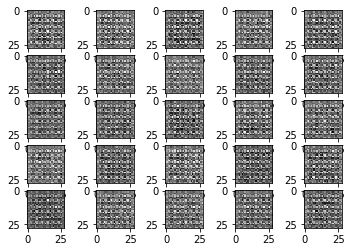

gen loss: 2.11337
disc loss: 42.3724
gen loss: 2.80511
disc loss: 26.9619
gen loss: 3.51757
disc loss: 16.6581
gen loss: 4.13164


KeyboardInterrupt: 

In [42]:
itr = 0
n_epochs = 500

# 学習
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(n_epochs):
    images = mnist.test.images
    np.random.shuffle(images)
    N = len(images)


    # batch_size毎のfor
    for start in range(0, N-batch_size, batch_size):
        end = start + batch_size
                     
        # 正規化
        img_bach = images[start:end].reshape([-1, 28,28,1]) / 255.
        random_Z = np.random.uniform(-1,1, size=[batch_size, latent_dim]).astype(np.float32)

        if itr%2==0:
            # 偶数番目はGeneratorを学習
            feed_dict = {Z: random_Z}
            _, gen_loss = sess.run([optimizer_g, gen_cost], feed_dict=feed_dict) 
            #discrim_loss_val, p_real_val, p_gen_val = sess.run([d_cost_tf, p_real, p_gen], feed_dict={Z_tf:Zs, image_tf:Xs})
            #print("=========== updating G ==========")
            #print("iteration:", itr)
            print("gen loss:", gen_loss)
            #print("discrim loss:", discrim_loss_val)
        else:
            # 奇数番目はDiscriminatorを学習
            feed_dict = {Z: random_Z, img_real: img_bach}
            _, discrim_loss = sess.run([optimizer_d, discrim_cost], feed_dict=feed_dict)
            #gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen], 
              #                                             feed_dict={Z_tf:Zs, image_tf:Xs})
            #print("=========== updating D ==========")
            #print("iteration:", itr)
            print("disc loss:", discrim_loss)
            #print("discrim loss:", discrim_loss_val)


        #print("Average P(real)=", p_real_val.mean())
        #print("Average P(gen)=", p_gen_val.mean())
        itr += 1
        
        if itr %10==0:
            feed_dict = {Z: random_Z}
            img = sess.run( [img_gen], feed_dict=feed_dict  )
            for i in range(25):
                plt.subplot( 5, 5, i+1 )
                plt.imshow( img[0][i].reshape(28,28), cmap="gray" )
            plt.show()
